<h1> Analyzing idiosyncratic volatility of equity options</h1>
_Canari.dev (www.canari.dev), April-2021_

You will need a valid A7 subscription to run it.
For this, please go to : https://www.mds.deutsche-boerse.com/mds-en/analytics/A7-analytics-platform

** By how much can we reduce the variance of the implicit volatility by taking out the hedgeable part ? **

Abstract :
The idea is that the volatility of a single stock option is clearly linked to the underlying's moves.
It is also linked to the volatility of the broader market which can be represented by the reference index (here Eurostoxx50)
This Notebook will show how much of the variance of the volatility time series can be explained by those two parameters

In [17]:
# You will first need to run a calibration thanks to the following git:
# https://github.com/canari-dev/Calibrating-implicit-volatility-surface-with-Deutsche-Boerse-A7
# Indicate here in which folder you have saved the Parameters files thus generated :

# File format must be : "Params_" + udl + ".pkl"

folder = 'C:/Users/pvamb/PycharmProjects/Core/PyData/parameters/'

# and some imports
import numpy as np
import pandas as pd
import pickle
import statsmodels.api as sm
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'



In [18]:
# This function must be run once.
# It create a histo_ATF pickle in 'folder', compiling the ATM vol of selected underlyings

def pre_load(udl_list):
    df = pd.DataFrame()
    for udl in udl_list:
        print(udl)
        df_udl = pd.read_pickle(folder + "/Params_" + udl + ".pkl")
        # The parameter file doesn't save the ATM vol directly but a spline function.
        # The ATM vol is obtained by running the spline function for monyness=0
        df[(udl, "ATF")] = df_udl.apply(lambda x: (x.spline_bid(0) + x.spline_ask(0)) / 2, axis="columns")
        df[(udl, "FWD")] = df_udl["Fwd"]

    df.columns = pd.MultiIndex.from_tuples(df.columns, names=["udl", "param"])
    df.to_pickle(folder + "/histo_ATF.pkl")

In [19]:
#It is always best to eliminate outliers of time series with a cap/floor
def cap_floor(df, cap):
    std = df.std() * cap
    for col in df.columns:
        df[col] = np.minimum(np.maximum(df[col], -std[col]), std[col])
    return df

# Despite normalizing the moves in sqrt(Time To Maturity), it is better to focus on a specific range of maturities
def filter_matu(df, minTTM, maxTTM):
    df = df.loc[(df.TTM>minTTM*365) & (df.TTM<maxTTM*365)]
    return df

In [20]:
# This function builds the time series of the variation of ATM (resp. fixed strike vol) over a certain time-lag
# For ATM vol, the differentiation it is just a matter of shifting the time series
# For fixed strike, it is more complicated as we need to shift the forward and then calculate the vol on the
# corresponding strike using associated the moneyness as parameter of the spline functions.

def get_df_var(mode, lag, udl_list, minTTM, maxTTM):
    if mode == "ATF":
        df = pd.read_pickle(folder + "/histo_ATF.pkl")
        df_var = pd.DataFrame()

        matu_list = sorted(list(set(df.index.get_level_values(1))))
        for udl in udl_list:
            print('   ' + udl)
            for matu in matu_list:
                df_matu = df[udl].xs(matu, level=1, drop_level=False)
                df_matu["var_ATF"] = df_matu.ATF.shift(-lag) - df_matu.ATF
                df_matu["var_FWD"] = df_matu.FWD.shift(-lag) / df_matu.FWD - 1
                df_matu['udl'] = udl
                df_matu.set_index('udl', append=True, inplace=True)
                df_var = df_var.append(df_matu[["var_ATF", "var_FWD"]])

        return df_var


    elif mode == "Fixed_Strike":

        df = pd.DataFrame()
        df_var = pd.DataFrame()
        for udl in udl_list:
            print(udl)
            df_udl = pd.read_pickle(folder + "/Params_" + udl + ".pkl")

            matu_list = list(set(df_udl.index.get_level_values(1)))
            for matu in matu_list:
                df_matu = df_udl.xs(matu, level=1, drop_level=False)
                df_matu['Fwd'] = df_matu['Fwd'].astype('float64')
                df_matu['Fwd_shift'] = df_matu['Fwd'].shift(-lag)
                df_matu['moneyness'] = np.log(df_matu['Fwd_shift'] / df_matu['Fwd'])
                df_matu["ATF_K"] = df_matu.apply(lambda x: (x.spline_bid(x.moneyness) + x.spline_ask(x.moneyness)) / 2, axis="columns")
                df_matu["ATF"] = df_matu.apply(lambda x: (x.spline_bid(0) + x.spline_ask(0)) / 2, axis="columns")
                df_matu["var_ATF"] = df_matu["ATF"].shift(-lag) - df_matu["ATF_K"]
                df_matu['udl'] = udl
                df_matu.set_index('udl', append=True, inplace=True)
                df_matu["var_FWD"] = df_matu.Fwd.shift(-lag) / df_matu.Fwd - 1
                df_var = df_var.append(df_matu[["var_ATF", "var_FWD"]])

        return df_var

In [21]:
# Time to use the functions defined above. 
# First the pre_load (for ATM vols)
udl_list = ["OESX", "ALV", "ASM", "ALV", "SIE"]
pre_load(udl_list)

OESX
ALV
ASM
ALV
SIE


In [22]:
# No need to rerun the preload when you test the following part on different lags

lag = 100 # time step is 5 minutes so 100 corresponds to circa 1 day (500 minutes of open market)
df_var = {}
minTTM = 2.0/12 #in years
maxTTM= 1.0 #in years
cap_std = 3.0 #in std devs


for mode in ['ATF', 'Fixed_Strike']:
    print(mode)
    df_var[mode] = get_df_var(mode, lag, udl_list, minTTM, maxTTM)
    df_var_ref = df_var[mode].loc[df_var[mode].index.get_level_values(2) == 'OESX']
    df_var_ref.columns = [elt + '_ref' for elt in df_var_ref.columns]
    df_var[mode] = df_var[mode].loc[df_var[mode].index.get_level_values(2) != 'OESX']
    df_var[mode]['udl'] = df_var[mode].index.get_level_values(2)
    df_var[mode] = df_var[mode].merge(df_var_ref, how='outer', right_on=['ts', 'matu'], left_on=['ts', 'matu'])
    df_var[mode].set_index('udl', append=True, inplace=True)

    df_var[mode] = df_var[mode].dropna().astype("float64")
    print('  Number of points : {}'.format(df_var[mode].shape[0]))


with open(folder + '/df_var_' + str(lag) + '.pkl', "wb") as output_file:
    pickle.dump(df_var, output_file)

ATF
   OESX
   ALV
   ASM
   ALV
   SIE
  Number of points : 1400037
Fixed_Strike
OESX
ALV
ASM
ALV
SIE
  Number of points : 1435231


Regressing var_ATF on ['var_FWD_TTMsq']
ATF
nb of lines : 317488
Y variance : 0.23
% of var explained by regressors : 0.51


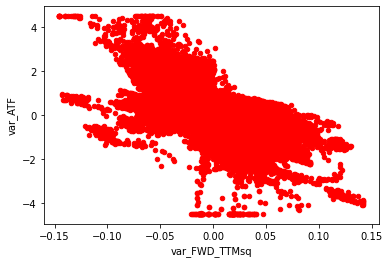

Fixed_Strike
nb of lines : 322539
Y variance : 0.12
% of var explained by regressors : 0.13


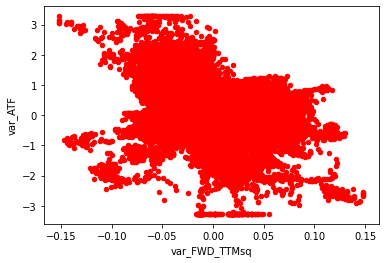

Regressing var_ATF on ['var_FWD_TTMsq', 'var_ATF_ref', 'var_FWD_ref_TTMsq']
ATF
nb of lines : 317488
Y variance : 0.18
% of var explained by regressors : 0.70


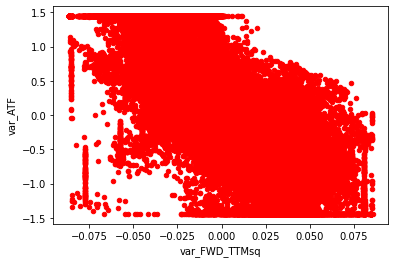

Fixed_Strike
nb of lines : 322539
Y variance : 0.08
% of var explained by regressors : 0.41


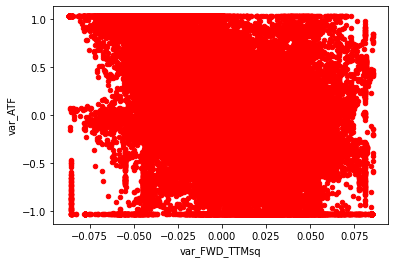

Regressing var_ATF_ref on ['var_FWD_ref_TTMsq']
ATF
nb of lines : 317488
Y variance : 0.21
% of var explained by regressors : 0.84


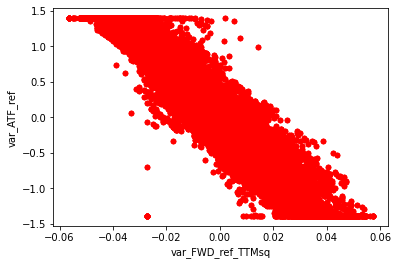

Fixed_Strike
nb of lines : 322539
Y variance : 0.04
% of var explained by regressors : 0.30


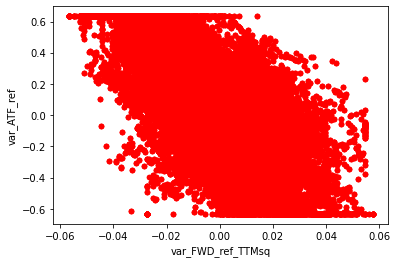

In [24]:
# We can now run our linear regression

# First on the spot variation (realized smile) :
YX1 = ("var_ATF", ["var_FWD_TTMsq"])
# Then on underlying + Eurostoxx index :
YX2 = ("var_ATF", ["var_FWD_TTMsq", "var_ATF_ref", "var_FWD_ref_TTMsq"])
#Finally we look at the index itself by regressing on its :
YX3 = ("var_ATF_ref", ["var_FWD_ref_TTMsq"])


with open(folder + '/df_var_' + str(lag) + '.pkl', "rb") as input_file:
    df_var = pickle.load(input_file)

for Y_col, cols in [YX1, YX2, YX3]:
    print('Regressing {} on {}'.format(Y_col, cols))
    for mode in ['ATF', 'Fixed_Strike']:
        print(mode)
        # filter
        df_var[mode]["TTM"] = (df_var[mode].index.get_level_values(1).map(lambda x: pd.Timestamp(x)) - df_var[mode].index.get_level_values(0)).total_seconds() / 60.0 / 60.0 / 24.0
        df_var[mode] = filter_matu(df_var[mode], minTTM, maxTTM)
        df_var[mode] = cap_floor(df_var[mode], cap_std)
        df_var[mode] = df_var[mode].loc[df_var[mode].index.get_level_values(0) < pd.Timestamp('20200131')]

        # normalize fwd var
        df_var[mode]["TTMsq"] = df_var[mode]["TTM"].apply(lambda x: max(0.5 / 12, x / 365)) ** 0.5
        df_var[mode]["var_FWD_TTMsq"] = df_var[mode].var_FWD / df_var[mode].TTMsq
        df_var[mode]["var_FWD_ref_TTMsq"] = df_var[mode].var_FWD_ref / df_var[mode].TTMsq
        print('nb of lines : {}'.format(df_var[mode].shape[0]))
        model = sm.OLS(df_var[mode][Y_col], df_var[mode][cols])
        res = model.fit()
        # print(res.summary())
        print('Y variance : {:.2f}'.format(df_var[mode][Y_col].var()))
        df_var[mode]["var_ATF_idiosync"] = df_var[mode][Y_col] - np.dot(res.params, df_var[mode][cols].T)
        R2 = 1 - df_var[mode]["var_ATF_idiosync"].var() / df_var[mode][Y_col].var()
        print('% of var explained by regressors : {:.2f}'.format(R2))

        for col in cols[:1]:
            ax = df_var[mode].plot(kind='scatter', x=col, y=Y_col, color='r')
            plt.show()

